## **Machine Learning - WNBA Playoffs Prediction**
This notebook will focus on the undestanding of the data. We will be using SQLite to store the data due to its scalability & the fact that it's a relational schema.

https://docs.python.org/3/library/sqlite3.html

Import sqlite3 and connect to database file

### **Imports**

In [1]:
import pandas as pd
import sqlite3
import prep_utils as pu 
import raw_prep_utils as ru
import sys
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### **Database Connection Setup**

In [2]:
db = sqlite3.connect("db/ac.db")
db_cur = db.cursor()

[df_awards, df_coaches, df_players_teams, df_players, df_series_post, df_teams_post, df_teams] = pu.db_to_pandas(db)

In [3]:
final_rick = pu.calc_team_power_rat(df_players_teams,df_awards,df_players,df_teams,1)
print(final_rick.columns)
#oi = ru.merge_all_raw_data(df_teams,df_players_teams,df_coaches,df_awards,df_teams_post,1)
#print(oi.to_string())


Mean Squared Error for G: 0.25878031496063
Feature importance for G:
fg%: 0.13833704794426624
PER: 0.09986722500715102
PPM: 0.08855281626114131
3pt%: 0.08830287851232468
assists: 0.0833074660123795
ft%: 0.08311203673123047
PF: 0.07458242092205085
turnovers: 0.06460783811979544
steals: 0.05578704204336647
dRebounds: 0.05528148561439474
oRebounds: 0.053633630086392076
blocks: 0.051300963924443076
rebounds: 0.04810923804391156
dq: 0.013979775608013632
player_awards: 0.0012381351691389108

Mean Squared Error for C-F: 0.3297111111111112
Feature importance for C-F:
blocks: 0.2556975691850726
PER: 0.09859092353515445
PPM: 0.08679487611611382
turnovers: 0.08545843427131374
assists: 0.08039831138730538
ft%: 0.07832900212015313
fg%: 0.07188950719141342
steals: 0.05886491666633134
oRebounds: 0.04849629512889377
PF: 0.040450196429757806
rebounds: 0.03519137905714925
dRebounds: 0.034698467963579255
3pt%: 0.016283527992776867
dq: 0.008856592954985166
player_awards: 0.0

Mean Squared Error for C: 0.

***Prepare Coaches Dataframe***

In [4]:
df_new_coaches = pu.prepare_coaches(df_coaches, df_awards,1)
df_new_coaches = pu.group_coaches(df_new_coaches)
print(df_new_coaches.to_string())

Dropping Attribute lgID in Coaches...
Creating attribute coach previous regular season win ratio...
Creating attribute coach playoffs win ratio...
Creating attribute coach playoffs count...
Creating attribute coach awards count...
Dropping attribute post_wins..
Dropping attribute post_losses..
Dropping attribute won..
Dropping attribute lost..

Coaches Null Verification:
year                    0
tmID                    0
coachID                 0
coach_reg_wr            0
coach_po_wr             0
coach_playoffs_count    0
coach_awards            0
dtype: int64
     year tmID     coachID  coach_reg_wr  coach_po_wr  coach_playoffs_count  coach_awards
0       1  CHA  dunntr01wc      0.000000     0.000000                     0             0
1       1  CLE  hugheda99w      0.000000     0.000000                     0             0
2       1  DET  liebena01w      0.000000     0.000000                     0             0
3       1  HOU  chancva99w      0.000000     0.000000                  

***Prepare Players Dataframe***


In [5]:
df_new_players_teams = pu.prepare_player_teams(df_players_teams,df_awards,1)
#df_new_players_teams['PostPER'] = ((df_new_players_teams['PostfgMade'] * 85.910) + (df_new_players_teams['PostSteals'] * 53.897) + (df_new_players_teams['PostthreeMade'] * 51.757) + (df_new_players_teams['PostftMade'] * 46.845) + (df_new_players_teams['PostBlocks'] * 39.190) + (df_new_players_teams['PostoRebounds'] * 39.190) + (df_new_players_teams['PostAssists'] * 34.677) + (df_new_players_teams['PostdRebounds'] * 14.707) - (df_new_players_teams['PostPF'] * 17.174) - ((df_new_players_teams['PostftAttempted'] - df_new_players_teams['PostftMade']) * 20.091) - ((df_new_players_teams['PostfgAttempted'] - df_new_players_teams['PostfgMade']) * 39.190) - (df_new_players_teams['PostTurnovers'] * 53.897)) * (np.where(df_new_players_teams['PostMinutes'] == 0, 0, 1 / df_new_players_teams['PostMinutes']))
#df_new_players_teams['PER'] = ((df_new_players_teams['fgMade'] * 85.910) + (df_new_players_teams['steals'] * 53.897) + (df_new_players_teams['threeMade'] * 51.757) + (df_new_players_teams['ftMade'] * 46.845) + (df_new_players_teams['blocks'] * 39.190) + (df_new_players_teams['oRebounds'] * 39.190) + (df_new_players_teams['assists'] * 34.677) + (df_new_players_teams['dRebounds'] * 14.707) - (df_new_players_teams['PF'] * 17.174) - ((df_new_players_teams['ftAttempted'] - df_new_players_teams['ftMade']) * 20.091) - ((df_new_players_teams['fgAttempted'] - df_new_players_teams['fgMade']) * 39.190) - (df_new_players_teams['turnovers'] * 53.897)) * (np.where(df_new_players_teams['minutes'] == 0, 0, 1 / df_new_players_teams['minutes']))

Dropping Attribute lgID in Players_Teams...


***Prepare Teams Dataframe***

In [6]:
df_new_teams = pu.prepare_teams(df_teams,df_teams_post,1)
print(df_new_teams.to_string())

Dropping divID in Teams...
     year tmID  rank  playoff   o_fgm   o_fga  o_ftm  o_fta  o_3pm  o_3pa  o_oreb  o_dreb   o_reb  o_asts   o_pf  o_stl   o_to  o_blk   o_pts   d_fgm   d_fga  d_ftm  d_fta  d_3pm  d_3pa  d_oreb  d_dreb   d_reb  d_asts   d_pf  d_stl   d_to  d_blk   d_pts   min  team_playoffs_count   Winrate  PO_Winrate
0       9  ATL   0.0        0     0.0     0.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0     0.0  6825                    0  0.000000    0.000000
1      10  ATL   7.0        1   895.0  2258.0  542.0  725.0  202.0  598.0   340.0   737.0  1077.0   492.0  796.0  285.0  593.0  142.0  2534.0  1014.0  2254.0  679.0  918.0  172.0  502.0   401.0   864.0  1265.0   684.0  726.0  310.0  561.0  134.0  2879.0  6950                    0  0.117647    0.000000
2       1  CHA   0.0        0     0.0     0.0    0.0    0.0    0

In [7]:
df_new_player_rankings = pu.prepare_players_for_ranking(df_players_teams, df_awards)
feature_importance, df_new_players = pu.feature_importance_players(df_new_player_rankings, df_players,df_teams)



Mean Squared Error for G: 0.2697007874015748
Feature importance for G:
fg%: 0.13289791903467038
PER: 0.09754319740118564
3pt%: 0.09114053338766726
PPM: 0.08933943548415954
PF: 0.08106975271628754
ft%: 0.07827908616913883
assists: 0.07787910500347893
turnovers: 0.06756042990257993
steals: 0.05779304917004266
oRebounds: 0.056144828971727366
dRebounds: 0.05456822814876015
blocks: 0.05273315896977929
rebounds: 0.051327272010636096
dq: 0.010021133596657022
player_awards: 0.0017028700332293717

Mean Squared Error for C-F: 0.3315444444444445
Feature importance for C-F:
blocks: 0.2148048119964355
PER: 0.12087031247773843
ft%: 0.09240026372297734
assists: 0.09093204093017553
fg%: 0.08601902901608423
turnovers: 0.07997719666546994
PPM: 0.0779473717757406
dRebounds: 0.05125026280253609
steals: 0.04217587971173334
oRebounds: 0.041706782212045504
3pt%: 0.035615913321710414
PF: 0.03305768948172491
rebounds: 0.02266027297485771
dq: 0.010582172910770297
player_awards: 0.0

Mean Squared Error for C: 0

In [8]:
dfp_copy = df_new_players.copy()

df_rating_regular = pu.ranking_players(feature_importance, dfp_copy)
print('Best players in the regular season: ')
print(df_rating_regular)


Best players in the regular season: 
        playerID  year    rating
1074  jacksla01w     8  0.512167
1155  parkeca01w     9  0.499993
1655  leslili01w     5  0.499708
204   jacksla01w     4  0.499474
687   griffyo01w     1  0.497850
...          ...   ...       ...
860   weberma01w     8  0.049167
959   oneilkr01w     9  0.044945
1180  willili01w    10  0.044708
934   robincr01w     8  0.039927
1531  chambco01w     8  0.000000

[1805 rows x 3 columns]


In [9]:
df_rating_playoffs = pu.ranking_playoff_players(feature_importance, dfp_copy)
print('Best players in the playoffs: ')
print(df_rating_playoffs)

Best players in the playoffs: 
        playerID  year  PostRating
395    zollsh01w     9    0.060500
1393  zirkozu01w     4    0.060500
657   zellosh01w    10    0.354867
835    zarafr01w     6    0.353467
1322  zakalok01w     1    0.058367
...          ...   ...         ...
33    abrossv01w     5    0.223767
45    abrossv01w     6    0.068781
59    abrossv01w     7    0.068781
81    abrossv01w     9    0.233424
0     abrossv01w     2    0.068781

[1805 rows x 3 columns]


In [10]:
df_new_players = pd.merge(df_new_players, df_rating_regular, on=['playerID', 'year'], how='left')
df_new_players = pd.merge(df_new_players, df_rating_playoffs, on=['playerID', 'year'], how='left')
ratings = pu.team_player_ratings(df_new_players, df_teams)
ratings2 = pd.merge(ratings, df_teams[['year', 'tmID', 'playoff','rank']], on=['year', 'tmID'], how='left')
sorted_power_ratings = ratings2.sort_values(by=['year', 'cum_power_rating'], ascending=False)


    
print(sorted_power_ratings)
# Group by year and select the top 6 teams
top_teams_by_year = sorted_power_ratings.groupby('year').head(8)

# Count how many of the top 8 teams for each year made the playoffs
playoffs_made_by_year = top_teams_by_year.groupby('year')['playoff'].apply(lambda x: (x == 'Y').sum()).reset_index()

# Print or use the results
for index, row in playoffs_made_by_year.iterrows():
    print('Year ' + str(row['year']) + ' based on Power Ratings ' + str(row['playoff']) + '/8 best teams made the playoffs')

print('Ranking System Accuracy: ' + str(playoffs_made_by_year['playoff'].sum()/ (8*len(playoffs_made_by_year))) + '%')




     year tmID  cum_power_rating playoff  rank
132    10  DET          0.463078       Y     3
134    10  LAS          0.399216       Y     3
133    10  IND          0.340115       Y     1
140    10  SEA          0.337662       Y     2
137    10  PHO          0.302878       Y     1
..    ...  ...               ...     ...   ...
11      1  POR          0.000000       N     7
12      1  SAC          0.000000       Y     3
13      1  SEA          0.000000       N     8
14      1  UTA          0.000000       N     5
15      1  WAS          0.000000       Y     4

[142 rows x 5 columns]
Year 1 based on Power Ratings 3/8 best teams made the playoffs
Year 2 based on Power Ratings 5/8 best teams made the playoffs
Year 3 based on Power Ratings 5/8 best teams made the playoffs
Year 4 based on Power Ratings 4/8 best teams made the playoffs
Year 5 based on Power Ratings 4/8 best teams made the playoffs
Year 6 based on Power Ratings 5/8 best teams made the playoffs
Year 7 based on Power Ratings 8/8 

In [11]:

power_ratings = pu.team_power_rating(df_teams, df_new_players)
sorted_power_ratings = power_ratings.sort_values(by=['year', 'PowerRating'], ascending=[True, False])
    
print(sorted_power_ratings)
# Group by year and select the top 6 teams
top_teams_by_year = sorted_power_ratings.groupby('year').head(8)

# Count how many of the top 8 teams for each year made the playoffs
playoffs_made_by_year = top_teams_by_year.groupby('year')['playoff'].apply(lambda x: (x == 'Y').sum()).reset_index()

# Print or use the results
for index, row in playoffs_made_by_year.iterrows():
    print('Year ' + str(row['year']) + ' based on Power Ratings ' + str(row['playoff']) + '/8 best teams made the playoffs')

print('Ranking System Accuracy: ' + str(playoffs_made_by_year['playoff'].sum()/ (8*len(playoffs_made_by_year))) + '%')

     year tmID  PowerRating playoff  rank
5       1  LAS     0.344304       Y     1
8       1  NYL     0.341929       Y     1
3       1  HOU     0.336025       Y     2
12      1  SAC     0.323621       Y     3
9       1  ORL     0.315582       Y     3
..    ...  ...          ...     ...   ...
135    10  MIN     0.275417       N     5
136    10  NYL     0.273022       N     7
131    10  CON     0.266729       N     6
130    10  CHI     0.260946       N     5
138    10  SAC     0.235561       N     6

[142 rows x 5 columns]
Year 1 based on Power Ratings 8/8 best teams made the playoffs
Year 2 based on Power Ratings 8/8 best teams made the playoffs
Year 3 based on Power Ratings 8/8 best teams made the playoffs
Year 4 based on Power Ratings 7/8 best teams made the playoffs
Year 5 based on Power Ratings 7/8 best teams made the playoffs
Year 6 based on Power Ratings 7/8 best teams made the playoffs
Year 7 based on Power Ratings 7/8 best teams made the playoffs
Year 8 based on Power Ratings 8

In [12]:
best_colleges = pu.best_colleges(df_players_teams,df_teams,df_players)


print(best_colleges)

                    college  TotalPlayoffAppearances  CollegeRank
88                Tennessee                       21            1
17              Connecticut                       17            2
31                  Georgia                       15            3
86                 Stanford                       12            4
48           Louisiana Tech                       11            5
..                      ...                      ...          ...
80               Seton Hall                        1           14
25    Florida International                        1           14
82     Southern Mississippi                        1           14
50                    Maine                        1           14
0   Academy of Sport Moscow                        1           14

[113 rows x 3 columns]


In [13]:
awards = pu.player_awards(df_new_players,df_awards)


# get a player, order by year
player = awards[awards['playerID'] == 'leslili01w']
player = player.sort_values(by=['year'], ascending=[True])

print(player)


        playerID  year  award  cumulative_awards
2750  leslili01w     1      0                0.0
2751  leslili01w     2      3                0.0
2752  leslili01w     3      2                3.0
2753  leslili01w     4      0                5.0
2754  leslili01w     5      2                5.0
2755  leslili01w     6      0                7.0
2756  leslili01w     7      2                7.0
2757  leslili01w     8      0                9.0
2758  leslili01w     9      1                9.0
2759  leslili01w    10      0               10.0


In [14]:
teams = pu.team_ratings(sorted_power_ratings,10)
team = teams[teams['tmID'] == 'HOU']
print(team)

     year tmID  PowerRating playoff  rank  cum_Rating
3       1  HOU     0.336025       Y     2    0.000000
19      2  HOU     0.293739       Y     4    0.336025
35      3  HOU     0.287245       Y     2    0.314882
52      4  HOU     0.308599       Y     2    0.305670
65      5  HOU     0.256752       N     6    0.306402
78      6  HOU     0.275232       Y     3    0.296472
92      7  HOU     0.282704       Y     3    0.292932
105     8  HOU     0.271464       N     5    0.291471
119     9  HOU     0.259266       N     5    0.288970


In [15]:
colleges = pu.teams_colleges(df_new_players,best_colleges,df_teams)

colleges = colleges[colleges['tmID'] == 'IND']

ordered_colleges = colleges.sort_values(by=['year', 'CollegeRank'], ascending=[True, True])

print(ordered_colleges)

   tmID  year  CollegeRank   min  rank
43  IND     1     5.168872  6425     7
44  IND     2     5.448031  6475     6
45  IND     3     4.569650  6425     4
46  IND     4     5.996073  6875     5
47  IND     5     6.759708  6850     6
48  IND     6     4.771264  6925     2
49  IND     7     7.064672  6850     3
50  IND     8     8.205236  6875     2
51  IND     9     6.474676  6950     4
52  IND    10     6.009819  6925     1


Final Table for Testing

In [16]:
merged_data = pu.merge_all_data(df_new_coaches,df_new_teams,df_new_players_teams, ratings)
merged_data.drop('coachID',axis = 1, inplace = True)
merged_data = merged_data[merged_data['year'] != 1]



merged_data = pd.merge(merged_data, final_rick, on=['tmID', 'year'], how='left')

### **Feature Selection**
We will preparate the data in each table, by cleaning & formatting it so that it can be easily used by the machine learning models afterwards.

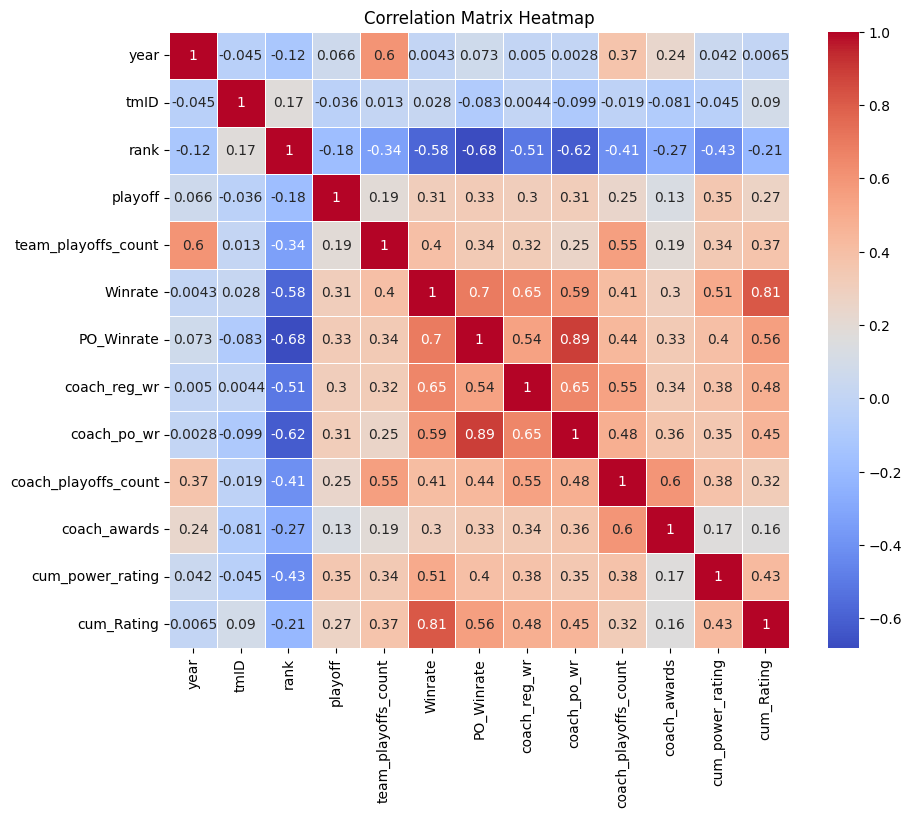

/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_mode

Best Parameters:  {'C': 10.0, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy:  0.6599999999999999
Test Accuracy:  0.6153846153846154


/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oliveira/.local/lib/python3.10/site-packages/sklearn/linear_mode

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.decomposition import PCA

import feature_selection as fs

label_encoder = LabelEncoder()


merged_data = merged_data.drop(columns=['o_fgm', 'o_fga', 'o_ftm', 'o_fta',
       'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf',
       'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta',
       'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf',
       'd_stl', 'd_to', 'd_blk', 'd_pts', 'min','p_GP', 'p_GS', 'p_minutes',
       'p_points', 'p_oRebounds', 'p_dRebounds', 'p_rebounds', 'p_assists',
       'p_steals', 'p_blocks', 'p_turnovers', 'p_PF', 'p_fgAttempted',
       'p_fgMade', 'p_ftAttempted', 'p_ftMade', 'p_threeAttempted',
       'p_threeMade', 'p_dq', 'p_PostGP', 'p_PostGS', 'p_PostMinutes',
       'p_PostPoints', 'p_PostoRebounds', 'p_PostdRebounds', 'p_PostRebounds',
       'p_PostAssists', 'p_PostSteals', 'p_PostBlocks', 'p_PostTurnovers',
       'p_PostPF', 'p_PostfgAttempted', 'p_PostfgMade', 'p_PostftAttempted',
       'p_PostftMade', 'p_PostthreeAttempted', 'p_PostthreeMade', 'p_PostDQ',
       'p_player_awards'], axis = 1)

"""
merged_data.drop(columns=['o_fgm', 'o_fga', 'o_ftm', 'o_fta',
       'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf',
       'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta',
       'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf',
       'd_stl', 'd_to', 'd_blk', 'd_pts', 'min','p_minutes'], axis = 1, inplace = True)
"""




merged_data['tmID'] = label_encoder.fit_transform(merged_data['tmID'])
correlation_matrix = merged_data.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()
#merged_data = fs.aggregate_stats_features(merged_data)

x = merged_data.drop('playoff', axis=1)
y = merged_data['playoff']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a dictionary of classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name} Accuracy: {accuracy}")